Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData, LondonGeoData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import LineString
import requests
import geopandas as gpd
import numpy as np
import networkx as nx
import torch
import torch_geometric

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

In [3]:
income = IncomeData()

In [4]:
met = MetData("Heathrow")

In [5]:
geography = LondonGeoData()

Load the London local authority shapefile:

In [6]:
london_authorities_gdf = geography.read("london-local-authorities-neighbours")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl. Use `wandb login --relogin` to force relogin


In [7]:
edge_pairs = geography.read("edge-pairs-array")

Load the resampled daily NO2 data:

In [ ]:
# daily_NO2_df = NO2.read("laqn-resample")
# daily_NO2_df.head(5)

Load the resampled daily income data:

In [8]:
daily_income_df = income.read("income-resample")

Load the resampled daily meteorological data:

In [9]:
# daily_met_df = met.resample_time_and_log(daily_income_df.index)
variables = ["temperature", "dew_point", "humidity", "precip", "wind_dir", "wind_speed", "peak_gust", "pressure"]
daily_met_df = met.read(variables, "met-resample")

Rename the local authorities in the income metadata using the LAQN metadata:

In [ ]:
# income_metadata_df = income.rename_local_authority_districts_and_log(reference="use_LAQN")

Load the renamed income metadata:

In [10]:
income_metadata_df = income.read("income-metadata")

Load the London shapefile for use in plotting:

In [ ]:
# london_authorities_gdf = geography.download_and_log()
# london_authorities_gdf = geography.rename_local_authority_districts_and_log(income_metadata_df["local_authority"].tolist(), "GDHI")
london_authorities_gdf = geography.read("london-local-authorities-renamed")

Spatially aggregate the LAQN data at the local authority level, with implementation of the algorithm used in Schwartz, 2000:

In [ ]:
# aggregated_NO2_df = NO2.local_authority_aggregation_and_log()

Load the spatially aggregated LAQN data:

In [11]:
aggregated_NO2_df = NO2.read("laqn-local-authority")

(8401, 33)


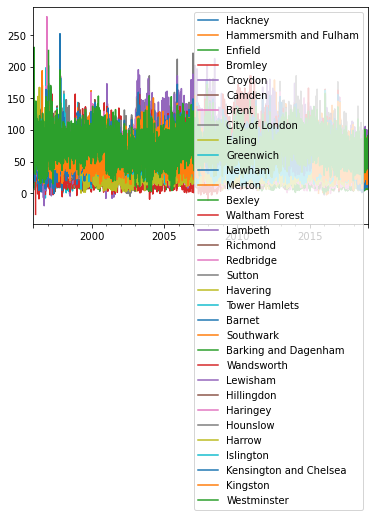

In [12]:
print(aggregated_NO2_df.shape)
aggregated_NO2_df.plot()
plt.show()

### Check missing data (NaN values)

#### LAQN

In [31]:
len(aggregated_NO2_df)

8401

In [39]:
aggregated_NO2_df.isna().sum()

Hackney                    115
Hammersmith and Fulham    3516
Enfield                      1
Bromley                   3657
Croydon                     18
Camden                       4
Brent                      760
City of London            2148
Ealing                       7
Greenwich                   51
Newham                     992
Merton                    6857
Bexley                      29
Waltham Forest            3836
Lambeth                   1848
Richmond                   234
Redbridge                 1509
Sutton                     105
Havering                   396
Tower Hamlets                4
Barnet                    3657
Southwark                  990
Barking and Dagenham      1716
Wandsworth                  40
Lewisham                   721
Hillingdon                 363
Haringey                   132
Hounslow                  1621
Harrow                    1303
Islington                  679
Kensington and Chelsea      89
Kingston                  3020
Westmins

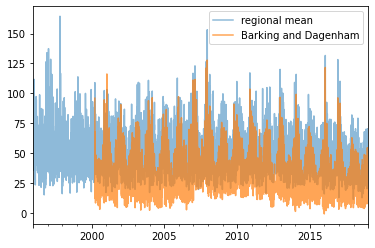

In [60]:
aggregated_NO2_df.mean(axis=1).plot(label="regional mean", alpha=0.5)
aggregated_NO2_df["Barking and Dagenham"].plot(alpha=0.7)
plt.legend()
plt.show()

##### Filling in data gaps using seasonal cycles and regional mean

In [62]:
from statsmodels.api import tsa

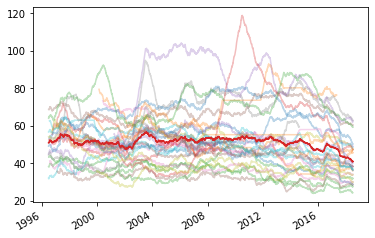

In [86]:
decomp_dict = {}

decomp = tsa.seasonal_decompose(aggregated_NO2_df.mean(axis=1).dropna(how="any"), model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
decomp_dict["regional_mean"] = decomp_df

for local_authority in aggregated_NO2_df.columns:
    decomp = tsa.seasonal_decompose(aggregated_NO2_df[local_authority].dropna(how="any"), model="additive", period=365)
    decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})
    decomp_dict[local_authority] = decomp_df
    decomp_dict[local_authority].trend.plot(label=f"{local_authority} trend", alpha=0.3)
    
decomp_dict["regional_mean"].trend.plot(label="regional mean trend")
# plt.legend(loc="upper right")
plt.show()


In [87]:
from sklearn.linear_model import LinearRegression

In [158]:
local_authority = "Kingston"

df = pd.concat([decomp_dict["regional_mean"].trend, decomp_dict[local_authority].trend], axis=1)
df.columns = ["regional_mean", local_authority]

<AxesSubplot:>

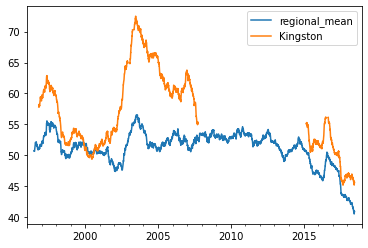

In [159]:
df.plot()

In [160]:
x = df.dropna()["regional_mean"].values.reshape(-1,1)
y = df.dropna()[local_authority].values
model = LinearRegression().fit(x, y)

In [161]:
model.coef_

array([1.58253195])

In [163]:
x_predict = df.loc[df[local_authority].isna()].dropna(subset="regional_mean")["regional_mean"].values.reshape(-1,1)
y_predict = model.predict(x_predict)
predict_df = pd.DataFrame(y_predict, index=df.loc[df[local_authority].isna()].dropna(subset="regional_mean").index, 
                         columns=[f"{local_authority}_predict"])
df = pd.concat([df, predict_df], axis=1)

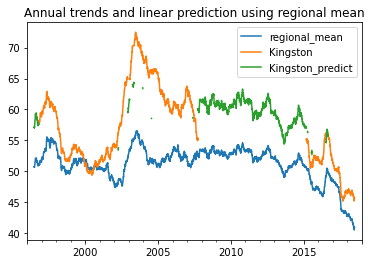

In [164]:
df.plot()
plt.title("Annual trends and linear prediction using regional mean")
plt.show()

#### Income data

In [40]:
daily_income_df.isna().sum()

E09000011    0
E09000003    0
E09000024    0
E09000002    0
E09000018    0
E09000005    0
E09000015    0
E09000006    0
E09000019    0
E09000025    0
E09000020    0
E09000007    0
E09000010    0
E09000012    0
E09000014    0
E09000017    0
E09000013    0
E09000028    0
E09000030    0
E09000029    0
E09000008    0
E09000026    0
E09000021    0
E09000023    0
E09000009    0
E09000016    0
E09000001    0
E09000031    0
E09000027    0
E09000022    0
E09000032    0
E09000004    0
E09000033    0
dtype: int64

#### Meteorological data

In [41]:
daily_met_df.isna().sum()

temperature       5
dew_point         5
humidity          5
precip         7671
wind_dir         11
wind_speed        8
peak_gust      7671
pressure          6
dtype: int64

### Graphs

Illustrate the graph setup over Greater London:

In [13]:
gdf = gpd.GeoDataFrame(edge_pairs.transpose(), columns=["x", "y"])

for column in gdf.columns:
    gdf[column] = gdf[column].map(london_authorities_gdf.centroid)

gdf.set_geometry([LineString(xy) for xy in zip(gdf.x, gdf.y)], inplace=True)

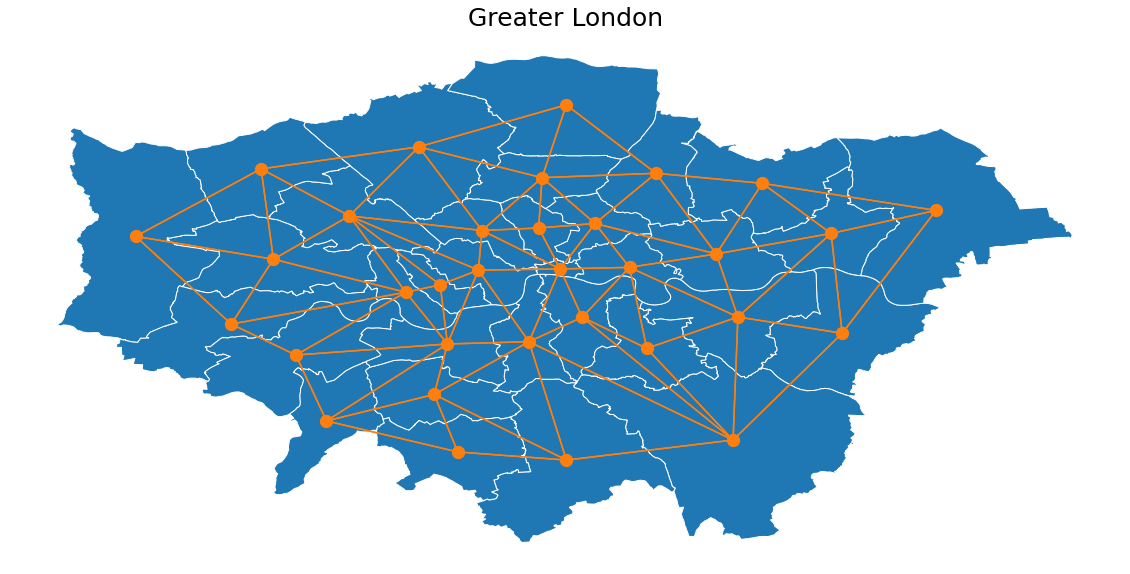

In [14]:
fig, ax = plt.subplots(figsize=(20, 15))

london_authorities_gdf.plot(ax=ax, edgecolors="w")
gdf.plot(ax=ax, color="tab:orange")
london_authorities_gdf.centroid.plot(ax=ax, marker="o", markersize=150, facecolors="tab:orange", edgecolors="tab:orange")
plt.axis("off")
plt.title("Greater London", fontsize=25)
plt.show()

Note that I haven't currently specified edge length.

Set up the node connections:

In [ ]:
# london_authorities_gdf, edge_pairs = geography.get_local_authority_neighbour_edges_and_log()

In [15]:
edge_index = torch.tensor(edge_pairs, dtype=torch.long)

In [16]:
node_index = london_authorities_gdf.index.values.reshape(-1,1)
x = torch.tensor(node_index, dtype=torch.float)

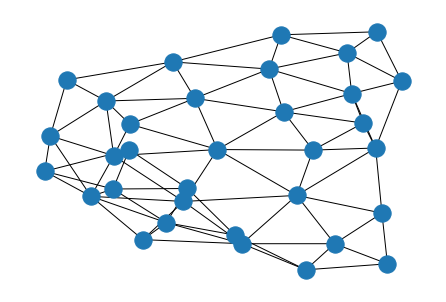

In [17]:
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(graph)

### Input feature processing to numpy arrays

Match up the date ranges for the local authority-level income and NO2 data:

In [18]:
def date_trim(df, start, end):
    df = df.loc[df.index >= start]
    df = df.loc[df.index <= end]
    return df

In [19]:
start, end = daily_income_df.index.min(), daily_income_df.index.max()

aggregated_NO2_datetrim_df = date_trim(aggregated_NO2_df, start, end)

In [20]:
local_authority_list = [] 

for i in london_authorities_gdf.index:
    local_authority = london_authorities_gdf.iloc[i]["local_authority"]
    income_dataset_code = income_metadata_df.loc[income_metadata_df["local_authority"]==local_authority].index.values[0]
    daily_income_array = daily_income_df[income_dataset_code].values
    daily_NO2_array = aggregated_NO2_datetrim_df[local_authority].values
    node_array = np.array([daily_NO2_array, daily_income_array])
    local_authority_list.append(node_array)
input_array = np.array(local_authority_list)

In [21]:
input_array.shape

(33, 2, 7671)

In [22]:
np.isnan(input_array).sum()

33315

Meteorological data for the whole Greater London region:

In [23]:
selected_variables = []
for column in daily_met_df.columns:
    nan_num = np.isnan(daily_met_df[column]).sum()
    print(f"{column}: {nan_num} NaN values")
    if nan_num < (len(daily_met_df) * 0.1):
        selected_variables.append(column)
print(selected_variables)

temperature: 5 NaN values
dew_point: 5 NaN values
humidity: 5 NaN values
precip: 7671 NaN values
wind_dir: 11 NaN values
wind_speed: 8 NaN values
peak_gust: 7671 NaN values
pressure: 6 NaN values
['temperature', 'dew_point', 'humidity', 'wind_dir', 'wind_speed', 'pressure']


In [24]:
for variable in selected_variables:
    array = np.tile(daily_met_df[variable].values, (len(london_authorities_gdf), 1, 1))
    input_array = np.concatenate((input_array, array), axis=1)

print(input_array.shape)

(33, 8, 7671)


In [25]:
nan_percent = np.isnan(input_array).sum() / len(input_array.flatten()) * 100
print(f"{np.round(nan_percent, 2)}% of all data points are NaN values.")

1.71% of all data points are NaN values.


Torch geometric data object:

In [26]:
data = torch_geometric.data.Data(x=input_array, edge_index=edge_index)

In [27]:
data

Data(x=[33, 8, 7671], edge_index=[2, 164])

In [28]:
# One data point instance is indexed by:
datapoint = input_array[:, :, 0].shape
torch_geometric.data.Data(x=datapoint, edge_index=edge_index)

Data(x=[2], edge_index=[2, 164])

In [29]:
# Have a look at the torch_geometric.data.Dataset() class.